In [151]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

try:
   import mitsuba as mi
except ImportError as e:
  os.system("pip install mitsuba")
  import mitsuba

from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, load_mesh

In [204]:
# Used for the sake of scemantics in this case
class SceneCFG:
  def __init__(self, scene_name = sionna.rt.scene.simple_street_canyon):
    self.scene_name = scene_name

In [311]:
class MyScene:
    """
    A Scene wrapper that exposes X, Y and Z bounds as attributes,
    creates camera presets for ease of use and forwards everything else to
    sionna.rt.scene.Scene.

    Mainly implemented for ease of collection of scene boundaries for transmitter
    placement during data generation.
    """
    def __init__(self, filename: str, merge_shapes=False, margin: float = 15.0):
      self._scene = load_scene(filename=filename, merge_shapes=merge_shapes)
      self.margin = float(margin)

      # bounding box
      self.bbox = self._scene.mi_scene.bbox()

      # raw bounds as attributes
      self.raw_xmin = float(self.bbox.min.x)
      self.raw_xmax = float(self.bbox.max.x)

      self.raw_ymin = float(self.bbox.min.y)
      self.raw_ymax = float(self.bbox.max.y)

      self.raw_zmin = float(0) # self.bbox.min.z
      self.raw_zmax = float(self.bbox.max.z)

      # margined bounds
      self.xmin = self.raw_xmin + self.margin
      self.xmax = self.raw_xmax - self.margin

      self.ymin = self.raw_ymin + self.margin
      self.ymax = self.raw_ymax - self.margin

      self.zmin = self.raw_zmin + self.margin
      self.zmax = self.raw_zmax  # subtract margin if you want

      if self.xmin > self.xmax or self.ymin > self.ymax:
          raise ValueError("Margin too large for scene extents.")

      # convinent cameras
      try:
        if filename == sionna.rt.scene.simple_street_canyon:
            z_top = 300
            y_side, z_side = -250, 150
            x_diag, y_diag, z_diag = self.raw_xmin * 2, self.raw_ymax * 2, 150
        elif filename == sionna.rt.scene.etoile:
            z_top = 1500
            y_side, z_side = -1000, 500
            x_diag, y_diag, z_diag = self.raw_xmin * 2.3, self.raw_ymax * 2.3, 600
        else:
            raise NotImplementedError("Camera presents not yet implemented for"
            f"'{filename.split('/')[-2]}'. Camera presets are set to None.")
      except NotImplementedError as e:
        print(e)
        self.top_down_camera, self.side_camera, self.diag_camera = None, None, None
      else:
        self.top_down_camera = Camera(position=[0, 0, z_top], look_at=[0, 0, 0])
        self.side_camera     = Camera(position=[0, y_side, z_side], look_at=[0, 0, 0])
        self.diag_camera     = Camera(position=[x_diag, y_diag, z_diag], look_at=[0, 0, 0])

    # Forward everything unknown to the underlying sionna.rt.Scene
    def __getattr__(self, name):
      return getattr(self._scene, name)

In [312]:
cfg = SceneCFG(sionna.rt.scene.etoile)
scene = MyScene(cfg.scene_name)

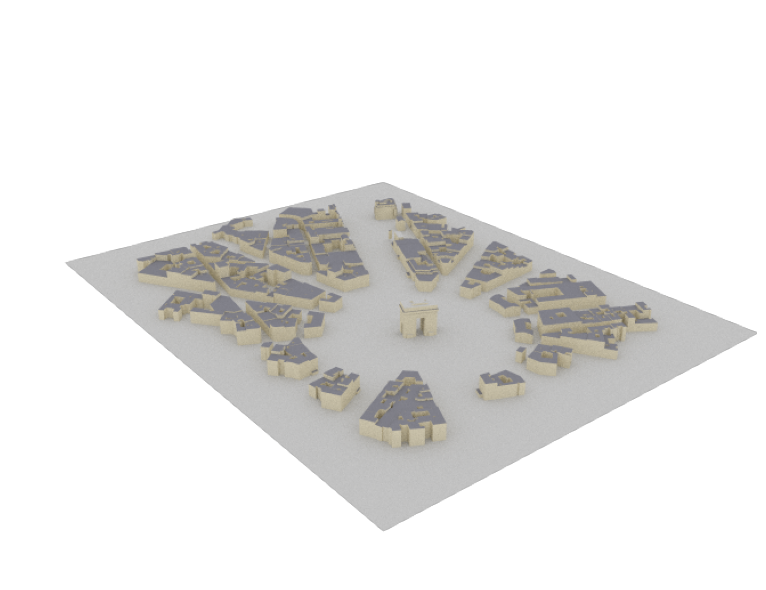

In [313]:
scene.render(camera=scene.diag_camera)
plt.show()

In [314]:
scene.remove('tx')
tx = Transmitter('tx',
                 position=[scene.xmin, scene.ymin, scene.zmax])
scene.add(tx)

In [315]:
scene.remove('tx1')
tx1 = Transmitter('tx1',
                  position=[scene.xmin, scene.ymax, scene.zmin])
scene.add(tx1)

In [316]:
scene.remove('tx2')
tx1 = Transmitter('tx2',
                  position=[scene.xmax, scene.ymax, scene.zmin])
scene.add(tx1)

In [317]:
scene.remove('tx4')
tx4 = Transmitter('tx4',
                  position=[scene.xmin, scene.ymin, scene.zmin])
scene.add(tx4)

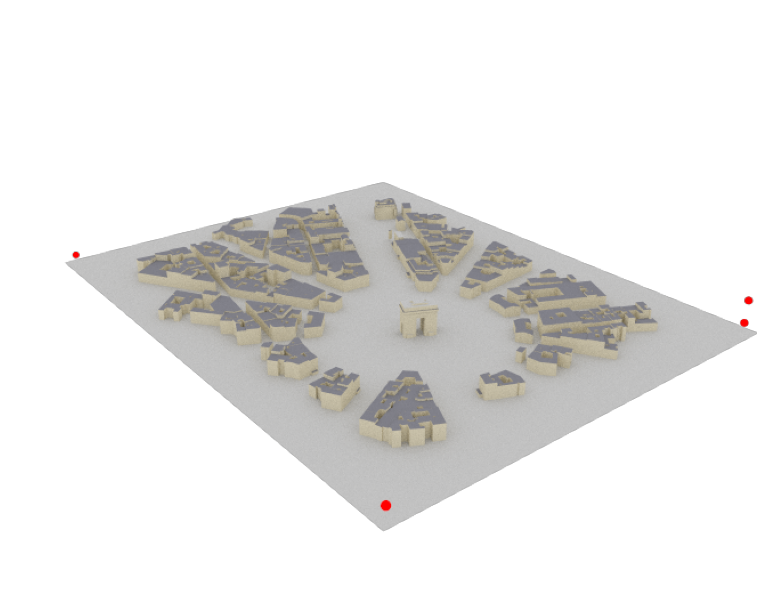

In [318]:
scene.render(camera=scene.diag_camera)
plt.show()